In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import math
from Visual import MapViser
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np

In [2]:
wss = gpd.read_file('./data/res/valid_cell.gpkg')

In [3]:
ipx = pd.read_csv('./data/net/ipx_loc.csv')
ls = pd.read_csv('./data/net/landingsite_loc.csv')

pop = pd.concat([ipx,ls])

In [4]:
world_map = gpd.read_file('./data/geo/Base/world_map.shp')

In [5]:
world_map = world_map[['name','geometry']]



In [6]:
wss_gdf = gpd.GeoDataFrame(wss,geometry=gpd.points_from_xy(x=wss['lon'],y=wss['lat']),crs='epsg:4326')

pop_gdf = gpd.GeoDataFrame(pop,geometry=gpd.points_from_xy(x=pop['longitude'],y=pop['latitude'],crs='epsg:4326'))

In [7]:
wss_gdf = gpd.sjoin(left_df=wss_gdf,right_df=world_map,predicate='within')
pop_gdf = gpd.sjoin(left_df=pop_gdf,right_df=world_map,predicate='within')

In [8]:
wss_gdf = wss_gdf.drop('index_right',axis=1)

pop_gdf = pop_gdf.drop('index_right',axis=1)



In [ ]:
def match_nearest_with_group_constraint(gdf_left, gdf_right, 
                                        group_col="name", 
                                        dist_col="distance_meters"):

    if gdf_left.crs != gdf_right.crs:
        gdf_right = gdf_right.to_crs(gdf_left.crs)
    
    original_crs = gdf_left.crs
    if original_crs.is_geographic:
        target_crs = gdf_left.estimate_utm_crs()
        gdf_left = gdf_left.to_crs(target_crs)
        gdf_right = gdf_right.to_crs(target_crs)
    
    results = []

    # 获取右侧所有可用的组名
    right_groups = gdf_right[group_col].unique()

    # 按组处理左侧数据
    for name_val, left_group in gdf_left.groupby(group_col):
        if name_val in right_groups:
            # 场景 A: 右侧存在相同组，进行组内最近匹配
            relevant_right = gdf_right[gdf_right[group_col] == name_val]
            matched = gpd.sjoin_nearest(left_group, relevant_right, how='left', distance_col=dist_col)
        else:
            # 场景 B: 右侧不存在相同组，进行全局匹配
            matched = gpd.sjoin_nearest(left_group, gdf_right, how='left', distance_col=dist_col)
        
        results.append(matched)

    # 合并结果
    final_gdf = pd.concat(results, ignore_index=True)

    # 恢复原始坐标系
    if original_crs.is_geographic:
        final_gdf = final_gdf.to_crs(original_crs)
        
    return final_gdf

In [ ]:
wss_dist = match_nearest_with_group_constraint(gdf_left=wss_gdf,gdf_right=pop_gdf,group_col='name',dist_col='dist_to_pop')

In [11]:
wss_dist = wss_dist.drop_duplicates(subset=['lon','lat'],keep='first')

In [12]:
wss_dist['dist_to_pop'] = wss_dist['dist_to_pop'] * 1e-3 #km

In [13]:
SPEED_OF_LIGHT_FIBER = 200.0 # 光速 (km/ms)
    
tortuosity = 1.8  # 绕路系数
overhead = 5.0   # 设备固定开销 (ms)

In [14]:
wss_dist['lantency'] = 2 * (wss_dist['dist_to_pop'] / SPEED_OF_LIGHT_FIBER) + overhead

In [15]:
wss_dist = wss_dist.sort_values(by='lantency',ascending=True)
wss_dist['gen_cum'] = wss_dist['gen'].cumsum() * 1e-6

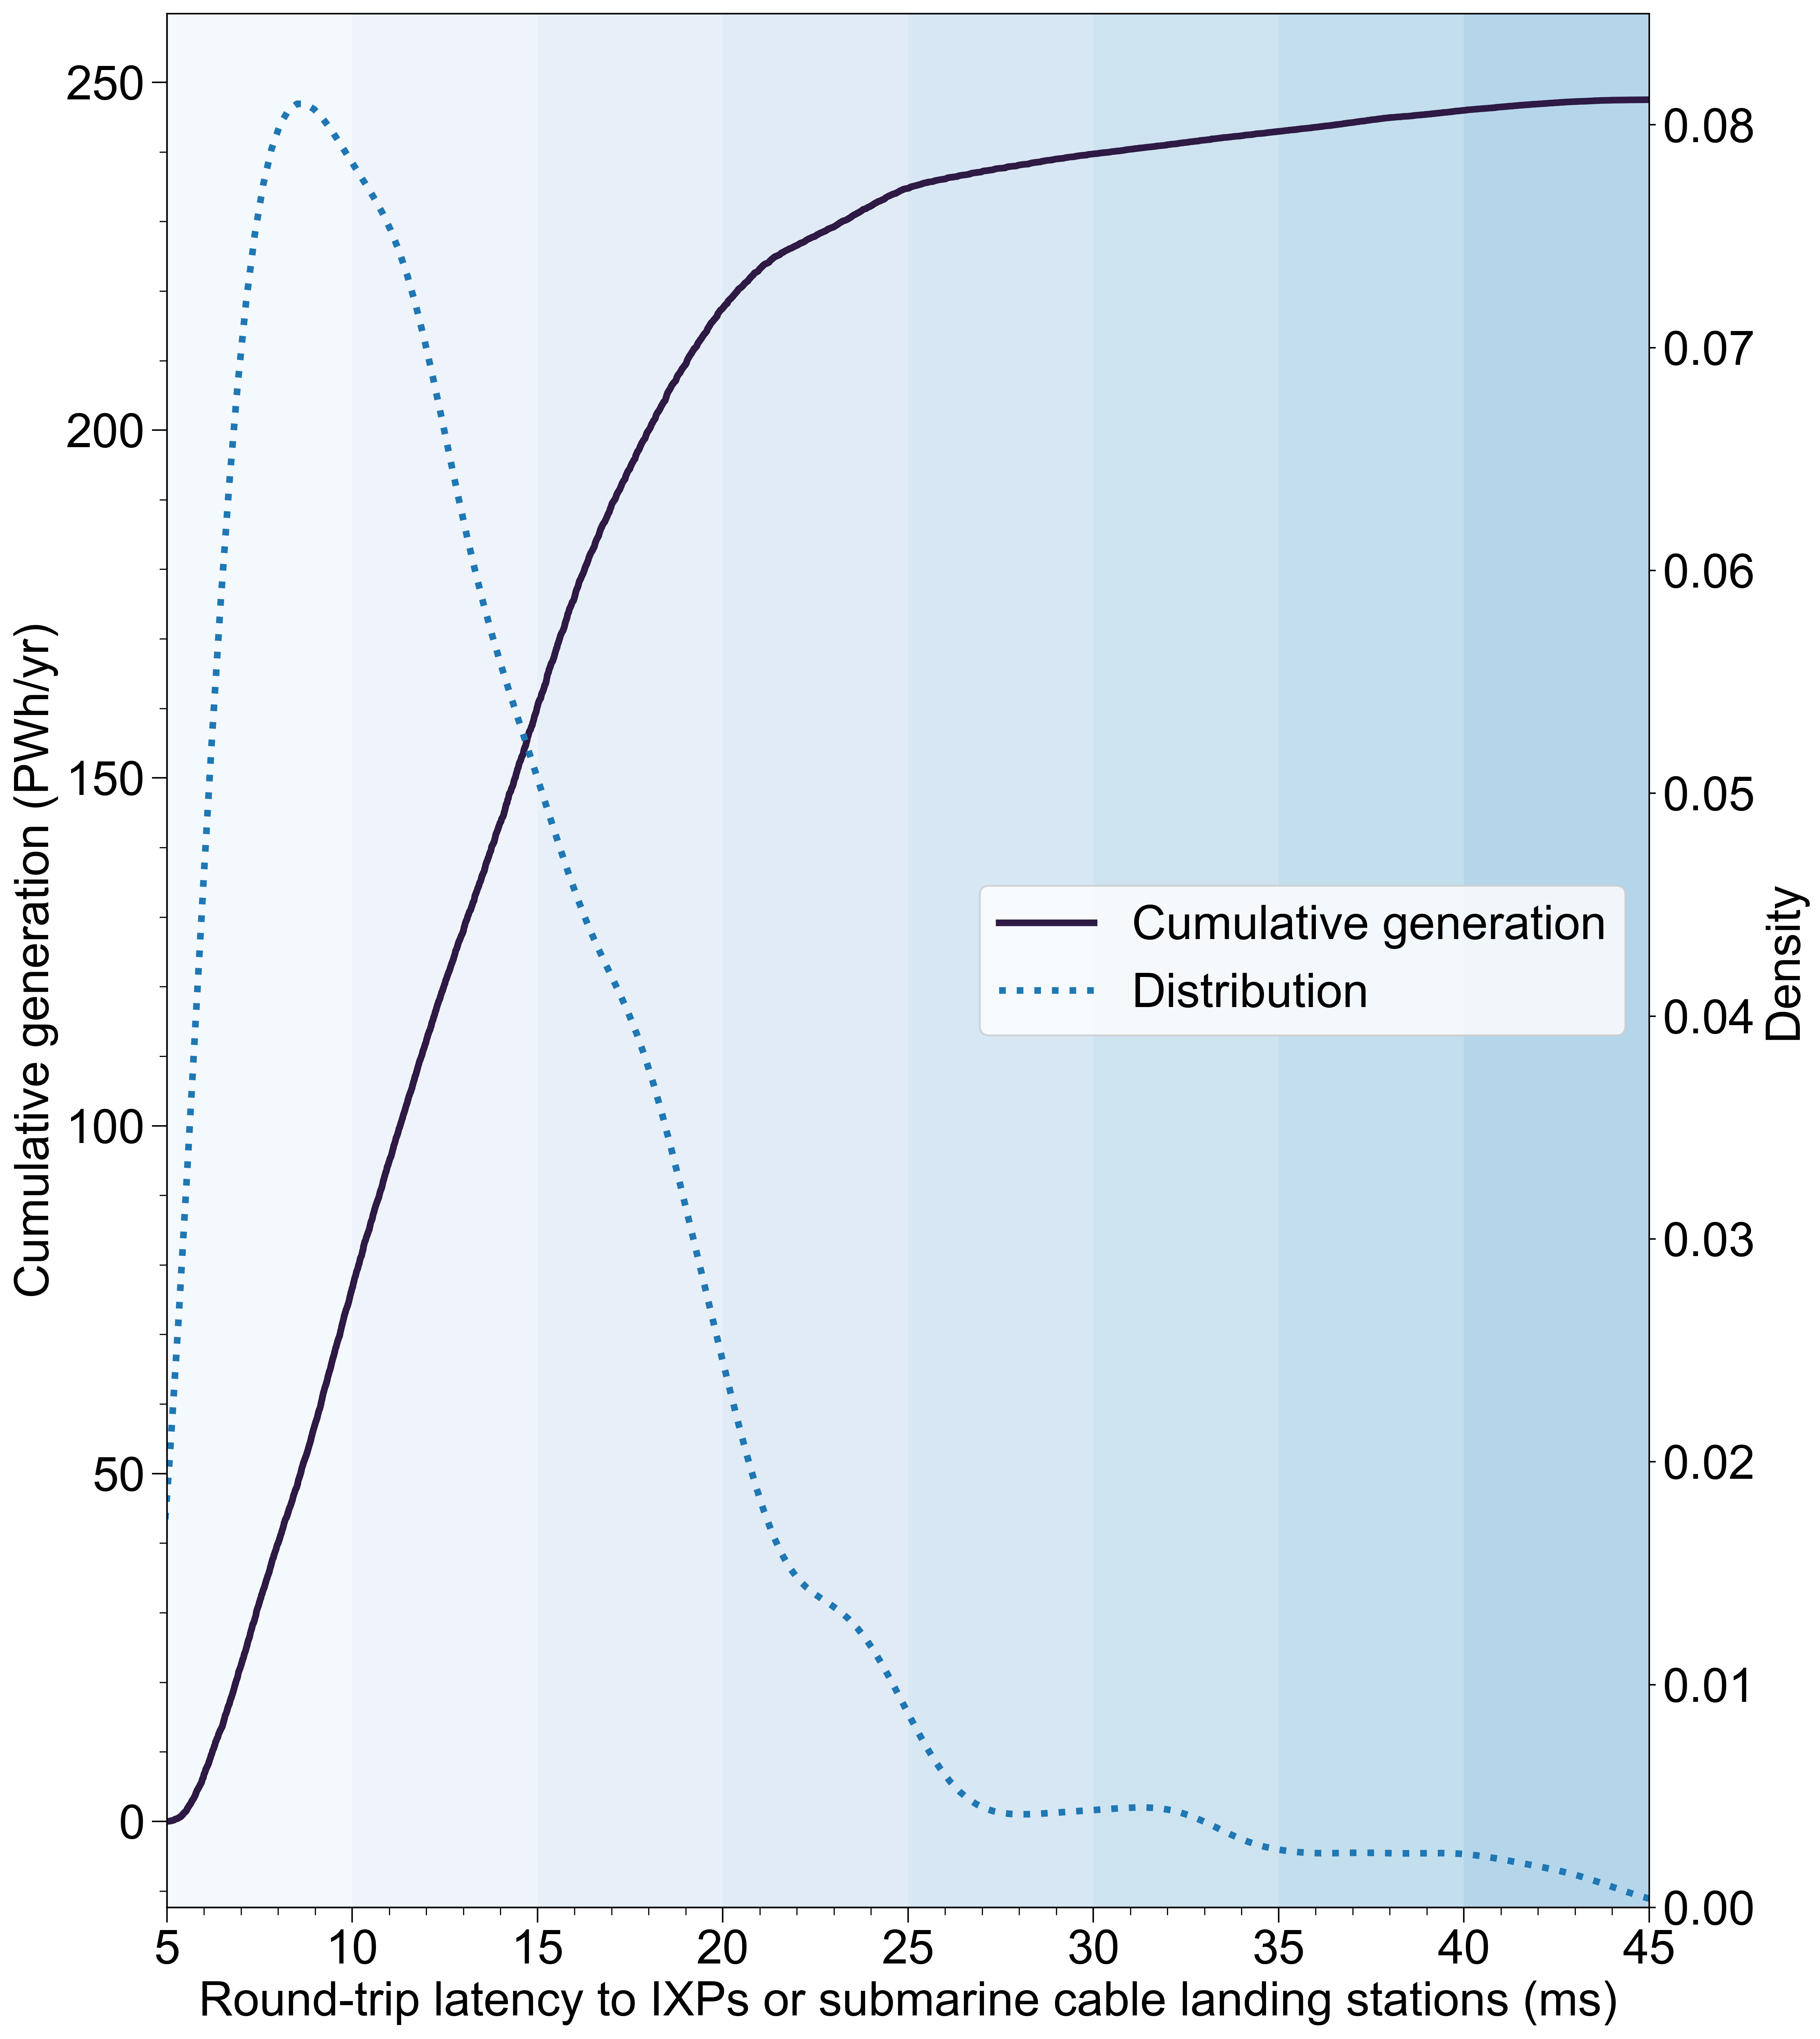

In [16]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 25

colors = {
        'low':'#2e1a44',
        'mid':'#6a3d9a',
        'high':'#cab2d6',
        '2024':'#11ade6',
        'freetrade':'green'
}

fig,ax = plt.subplots(figsize=(14,18),dpi=400)


intervals = np.arange(5, 55, 5)

# 选择一个色系。
# 推荐使用 'Reds', 'Oranges', 'Greys' 或 'Purples'
# 'Reds' 通常暗示"时延越高越不好"，语义很贴切
cmap = plt.get_cmap('Blues') 

# 循环绘制背景块
for i in range(len(intervals) - 1):
    start = intervals[i]
    end = intervals[i+1]
    
    # 限制绘制范围不超过x轴显示范围 (可选)
    if start > 45: break 
    
    intensity = (i / len(intervals)) * 0.55 + 0.05
    
    ax.axvspan(start, end, 
               color=cmap(intensity), 
               alpha=0.6,    # 透明度，确保不遮挡网格线
               lw=0,         # 无边框
               zorder=0)     # 确保背景在折线图的后面
    

ax.plot(wss_dist['lantency'], 
        wss_dist['gen_cum'], 
        color=colors['low'],
        linewidth=3.5,
        label='Cumulative generation')

ax_twinx = ax.twinx()

sns.kdeplot(ax=ax_twinx,data=wss_dist['lantency'],linewidth=3.5,ls=':')

ax.set_xlim(5,45)
#ax.set_ylim(-10,250)

ax.minorticks_on()

ax.tick_params(axis='y', 
               which='major', 
               length=8, 
               color='black')

ax.tick_params(axis='y', 
               which='minor', 
               length=4, 
               color='black')

ax.tick_params(axis='x', 
               which='minor', 
               length=4, 
               color='black')

ax.tick_params(axis='x', 
               which='major', 
               length=8, 
               color='black')

#ax.grid(axis='y', linestyle='--',which='both')

ax.plot([],[],ls=':',lw=3.5,label='Distribution')

ax.legend(loc='center right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Cumulative generation (PWh/yr)')
ax.set_xlabel('Round-trip latency to IXPs or submarine cable landing stations (ms)')
plt.savefig('./data/fig/Vis/lantency_ele.png',bbox_inches='tight')

In [17]:
map_vis = MapViser()

In [18]:
geo = []

for i,r in wss_dist.iterrows():
    geo.append(Polygon([
        (r['lon'],r['lat']),
        (r['lon']+0.25,r['lat']),
        (r['lon']+0.25,r['lat']-0.25),
        (r['lon'],r['lat']-0.25)
    ]))
    
wss_dist = gpd.GeoDataFrame(wss_dist,geometry=geo,crs='epsg:4326')

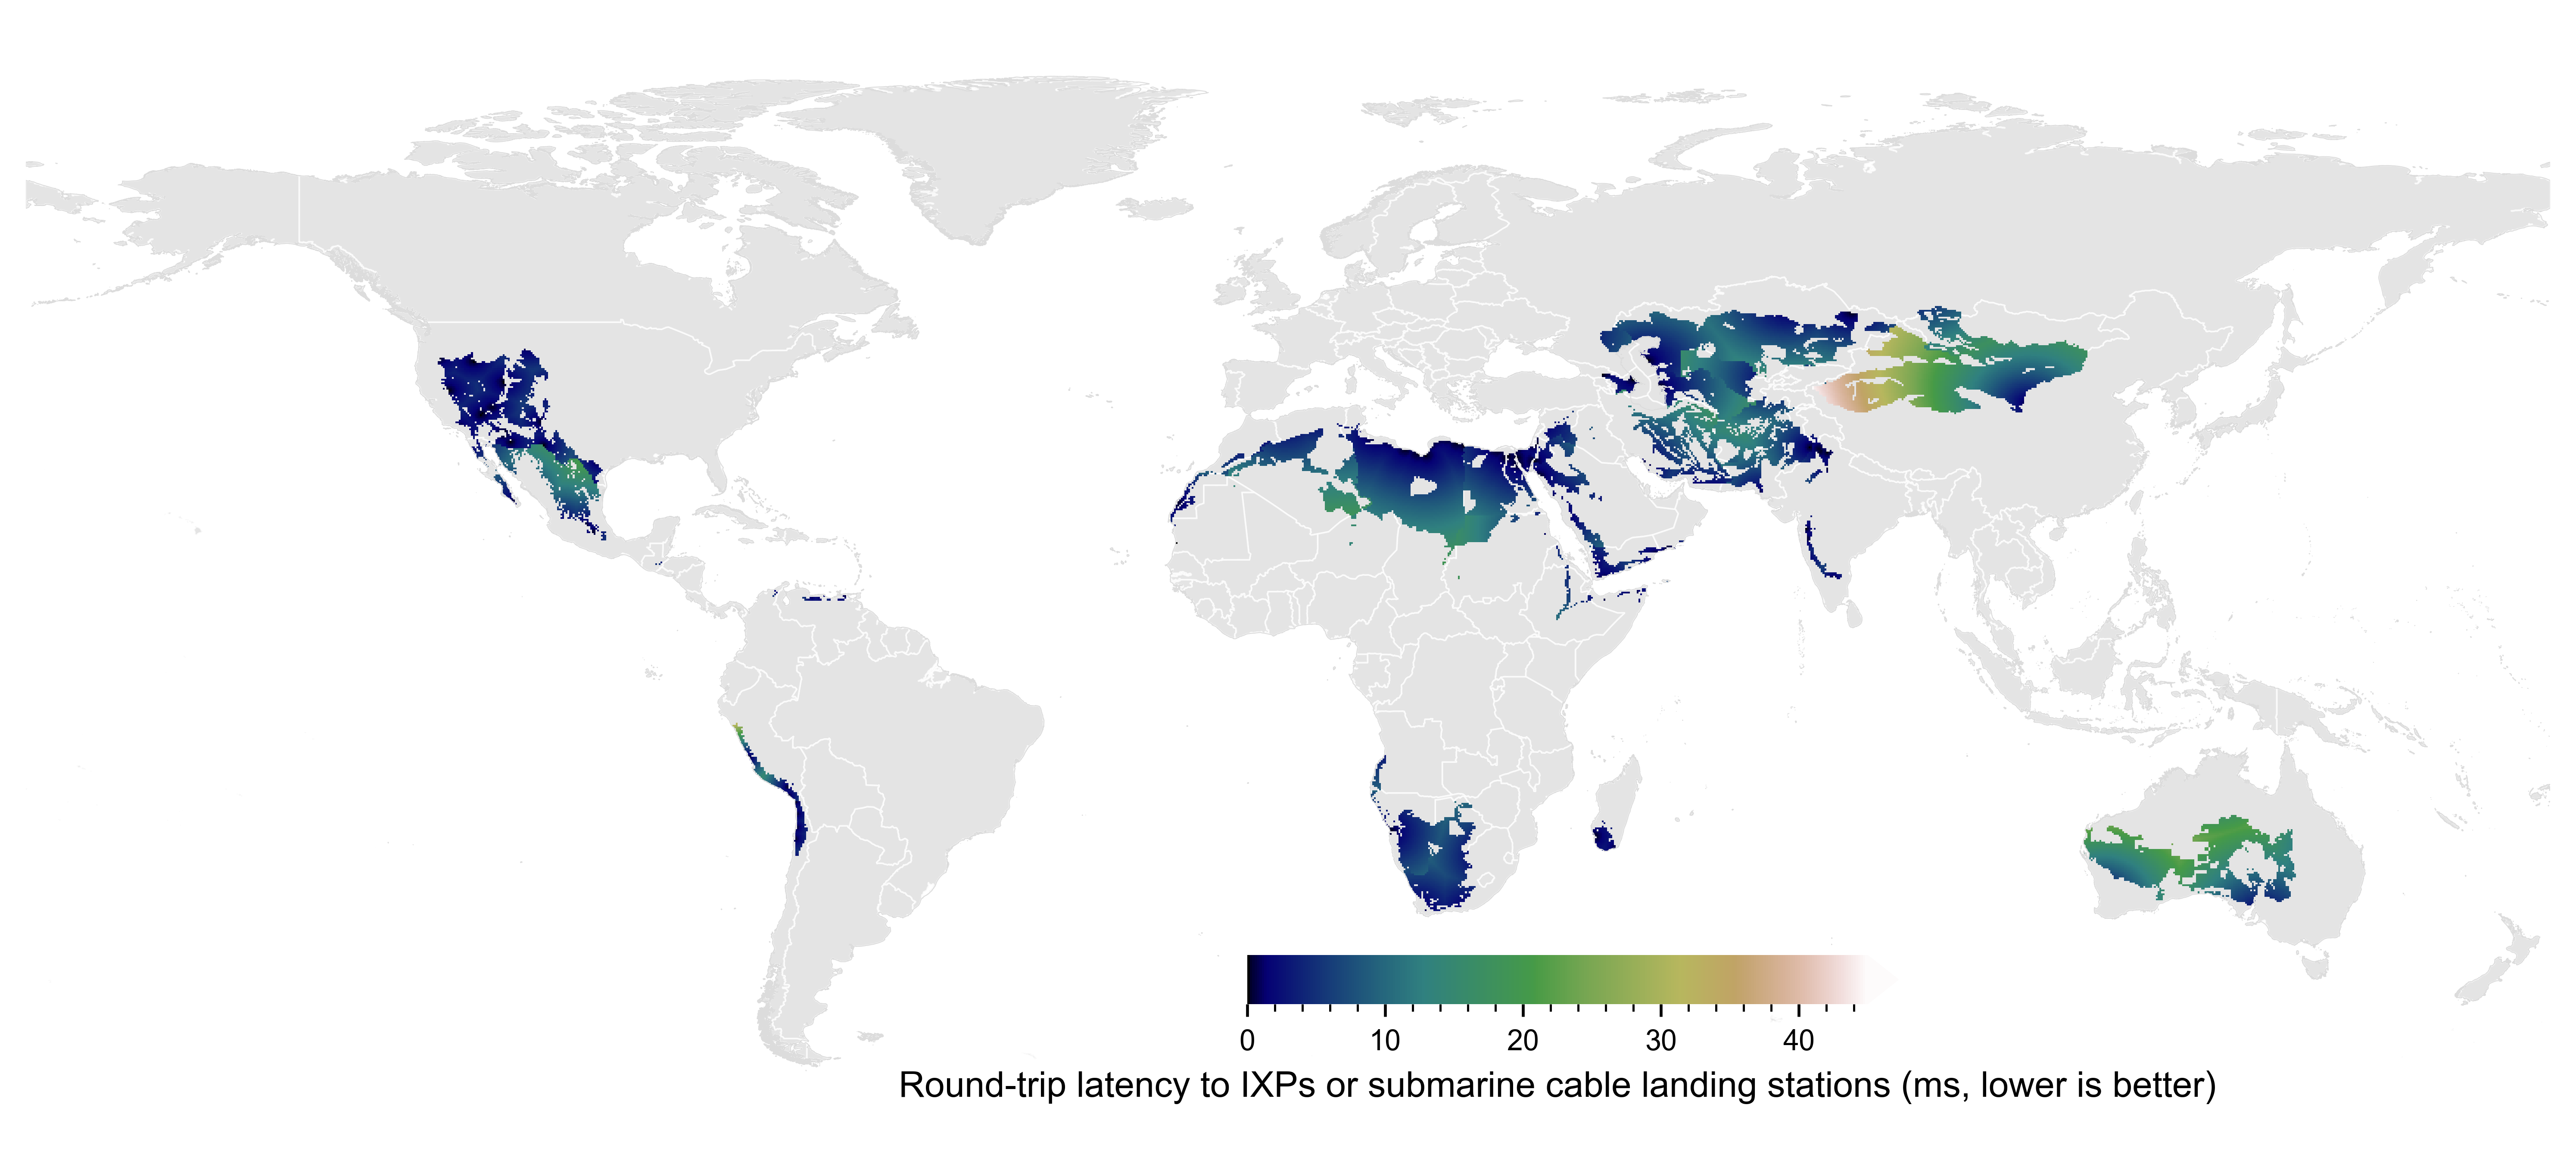

In [19]:

map_vis.set_font()

map_vis.set_bound_color('gainsboro')

fig,ax = map_vis.draw_attr_map(vis_shp=wss_dist,
                                attr_col='lantency',
                                cmap='gist_earth',
                                out_fig='./data/fig/Vis/lantency_map.png',
                                cbar_label='Round-trip latency to IXPs or submarine cable landing stations (ms)',
                                ub=45,
                                with_cbar=False,
                                bound_mode=2,
                                return_fig=True)

ax.set_xlim(-180,180)

map_vis.add_colorbar(fig=fig, 
                     loc=[0.5,0.3,0.2,0.0225],
                     vmax=45,
                     cmap='gist_earth',
                     orientation='horizontal',
                     label='Round-trip latency to IXPs or submarine cable landing stations (ms, lower is better)')

plt.savefig('./data/fig/Vis/lantency_map.png',bbox_inches='tight')